In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import glob
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
from sklearn.metrics import r2_score
import seaborn as sns
from theano import tensor as tt
from nilearn import datasets
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from nilearn.input_data import NiftiLabelsMasker
from sklearn.decomposition import NMF
from nilearn.image import resample_to_img
import nibabel as nib
from nilearn import signal
from scipy.stats import iqr
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

Please note that we rearranged the order of NMF components, or lesion atoms, in our publication,
i.e., according to hemisphere and anterior-posterior main weights.

Results may differ slightly in absolute terms given varying seeds.

In [2]:
Merged_clinical_subtype = pd.read_csv("/.../BMH/Final_models/Gasros/Merged_clinical_subtype_210111.csv")
Merged_nmf_lesions_subtype = np.array(pd.read_csv("/.../BMH/Final_models/Gasros/Merged_lesions_subtype_210111.csv", index_col=0))

In [3]:
sex_idx = [0,0,1,1]
n_sex = len(np.unique(sex_idx))
sex_study_idx = np.array(Merged_clinical_subtype.Sex_cardio).astype(int)
n_sex_study = len(np.unique(sex_study_idx))
n_components = 10

In [4]:
with pm.Model() as ancillary_subtype:
    
    b_all = ["b_1", "b_2", "b_3", "b_4", "b_5", "b_6", "b_7", "b_8", "b_9", "b_10"]
    
    mu = pm.Normal("a", mu=0, sd=1)
    
    sigma_b_hyper_hyper = pm.HalfCauchy("sigma_b_hyper", 5, shape=1)
    sigma_b_hyper = pm.HalfCauchy("sigma_b_all_hyper", sigma_b_hyper_hyper, shape=2)
    sigma_b_all = pm.HalfCauchy("sigma_b_all", sigma_b_hyper[sex_idx], shape=4)
    
    mu_b_all_hyper_hyper = pm.Normal('mu_b_all_hyper_hyper', mu=0, sd=10, shape=1)
    mu_b_all_hyper = pm.Normal('mu_b_all_hyper', mu=mu_b_all_hyper_hyper, sd=10, shape=2)
    mu_b_all = pm.Normal('mu_b_all', mu=mu_b_all_hyper[sex_idx], sd=10, shape=4)
    
    model_lower_vars = []
    for i_component in range(n_components):
            cur_beta = pm.Normal(b_all[i_component], mu=mu_b_all, sd=sigma_b_all, shape=4)
        
            mu = mu + cur_beta[sex_study_idx] * Merged_nmf_lesions_subtype[:, i_component]

            model_lower_vars.append(cur_beta)

    cov1_beta = pm.Normal("cov1_age", mu=0, sd=10, shape=1)
    mu = mu + cov1_beta * np.array(Merged_clinical_subtype.Age_scaled)
    cov2_beta = pm.Normal("cov2_age2", mu=0, sd=10, shape=1)
    mu = mu + cov2_beta * np.array(Merged_clinical_subtype.Age_scaled_2)
    cov3_beta = pm.Normal("cov3_sex", mu=0, sd=1, shape=1)
    mu = mu + cov3_beta * np.array(Merged_clinical_subtype.Sex)

    cov7_beta = pm.Normal("cov7_hypertension", mu=0, sd=1, shape=1)
    mu = mu + cov7_beta * np.array(Merged_clinical_subtype.HTN)
    cov8_beta = pm.Normal("cov8_dm", mu=0, sd=1, shape=1)
    mu = mu + cov8_beta * np.array(Merged_clinical_subtype.DM2)
    cov9_beta = pm.Normal("cov9_af", mu=0, sd=1, shape=1)
    mu = mu + cov9_beta * np.array(Merged_clinical_subtype.AF)
    cov10_beta = pm.Normal("cov10_cad", mu=0, sd=1, shape=1)
    mu = mu + cov10_beta * np.array(Merged_clinical_subtype.CAD)
    cov11_beta = pm.Normal("cov11_wmh", mu=0, sd=1, shape=1)
    mu = mu + cov11_beta * np.array(Merged_clinical_subtype.WMH_scaled)

    hyper_cov12_beta = pm.Normal("hyper_cov12_study", mu=0, sd=1)
    cov12_beta = pm.Normal("cov12_study", mu=hyper_cov12_beta, sd=1, shape=2)
    mu = mu + cov12_beta[np.array(Merged_clinical_subtype.Study)]
    
    # Model error
    eps = pm.HalfCauchy('eps',20)
    # Data likelihood
    NIHSS_like = pm.Normal('NIHSS_like', mu=mu, sd=eps, observed=np.array(Merged_clinical_subtype.NIHSS))

In [5]:
#with ancillary_subtype:
 #   ancillary_subtype_trace = pm.sample(draws=5000, n_init=1000, random_seed=1, chains=1)
#pm.save_trace(ancillary_subtype_trace, "/.../BMH/Final_models/Gasros/Ancillary_subtype_210111.trace", overwrite=True)

In [6]:
with ancillary_subtype:
    ancillary_subtype_trace = pm.load_trace("/.../BMH/Final_models/Gasros/Ancillary_subtype_210111.trace")

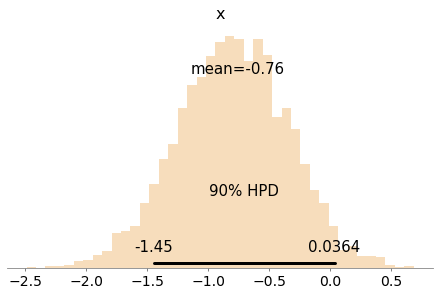

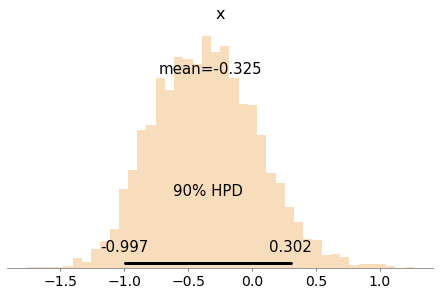

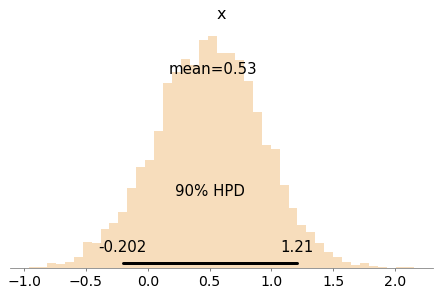

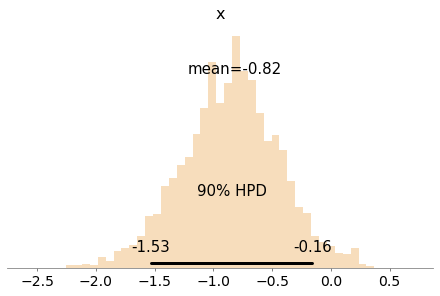

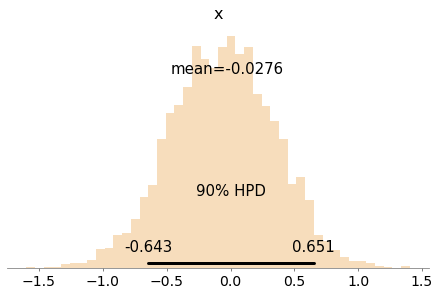

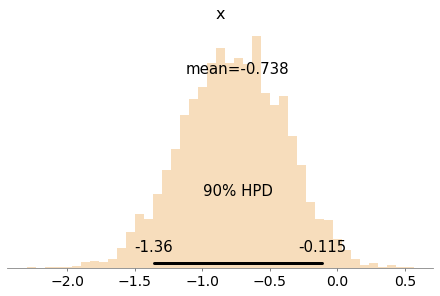

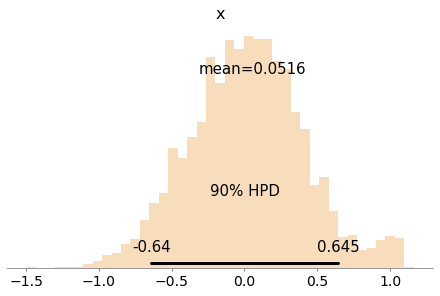

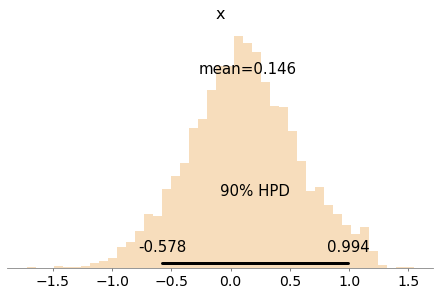

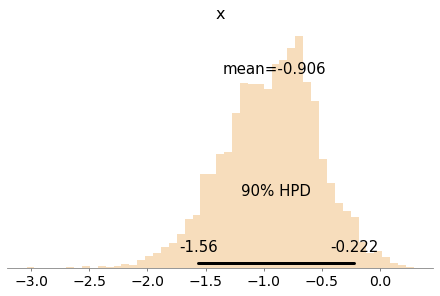

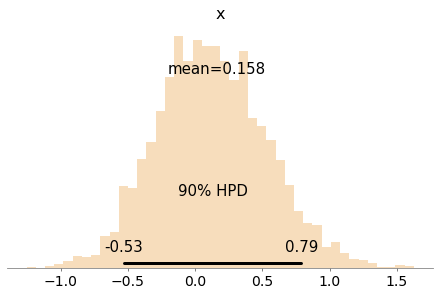

In [7]:
# Difference distributions: Men - Women with non-cardioembolic stroke
for i in range(1, 11):
    fig = pm.plot_posterior((ancillary_subtype_trace[1000:]['b_%i' % i][:,0] - ancillary_subtype_trace[1000:]['b_%i' % i][:,1]),round_to=3, kind='hist', credible_interval=0.9, color="#e99e40")

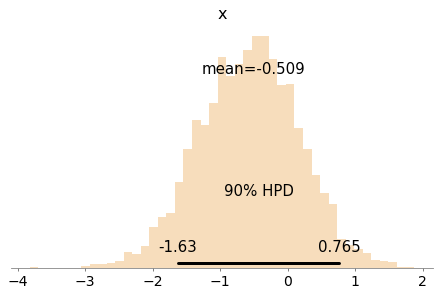

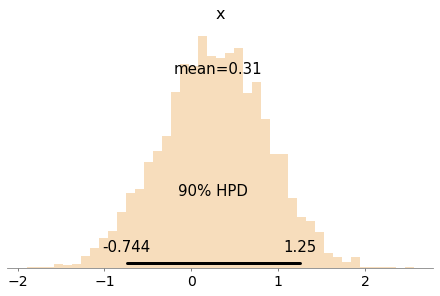

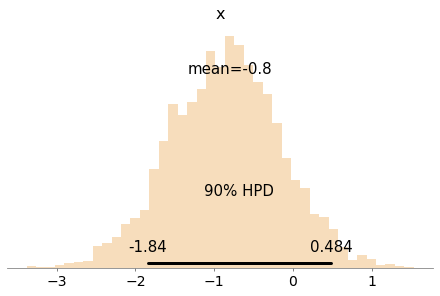

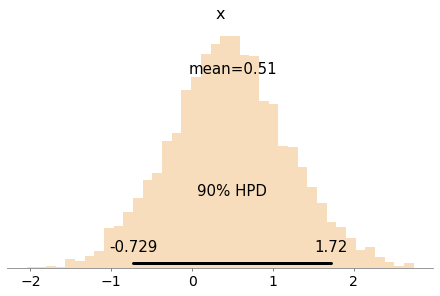

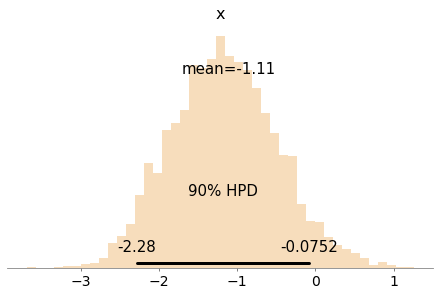

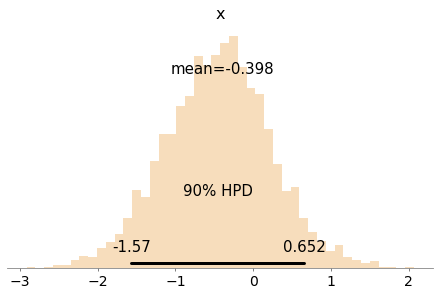

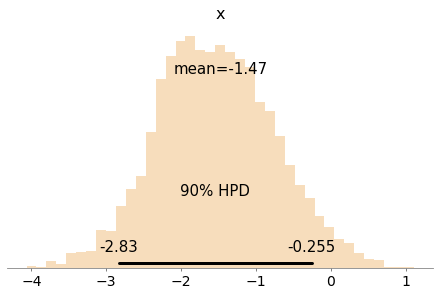

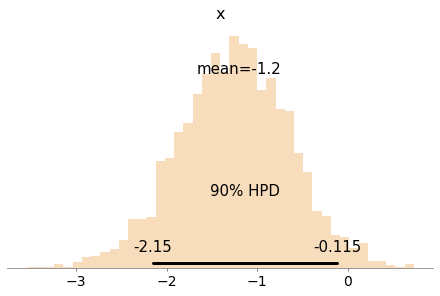

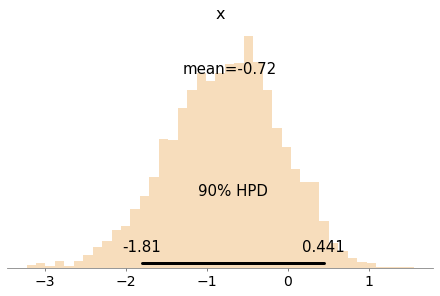

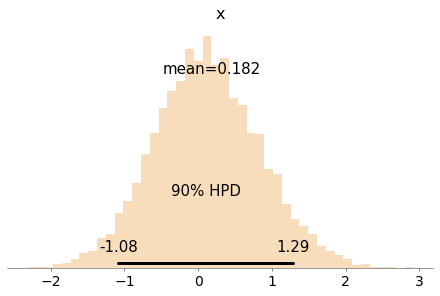

In [8]:
# Difference distributions: Men - Women with cardioembolic stroke
for i in range(1, 11):
    fig = pm.plot_posterior((ancillary_subtype_trace[1000:]['b_%i' % i][:,2] - ancillary_subtype_trace[1000:]['b_%i' % i][:,3]),round_to=3, kind='hist', credible_interval=0.9, color="#e99e40")